# Employee Attrition Analysis

In [1]:
import findspark
findspark.init("/home/ubuntu/spark-3.2.1-bin-hadoop2.7")
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import re
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_curve, auc
from graphviz import Digraph
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, mean, stddev, abs, when, expr, lit, rand, log
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, Bucketizer, QuantileDiscretizer, VectorAssembler, ChiSqSelector
from pyspark.ml.classification import DecisionTreeClassifier,LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from anytree import Node, RenderTree
# from pyspark.ml.classification import DecisionTreeClassificationModel
spark = SparkSession.builder.appName("jhon232_Employee_Attrition_Analysis").config("spark.driver.memory", "8g").config("spark.executor.memory", "15g").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/10 11:19:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Understanding

### Read Data

In [21]:
# read data in the format of csv
df_demographic = spark.read.csv("demographic_data.csv",header=True,inferSchema=True)
df_job_related = spark.read.csv("job_related_data.csv",header=True,inferSchema=True)

In [22]:
# inner join two datasets on EmployeeNumber
df = df_demographic.join(df_job_related, on="EmployeeNumber",how="inner")
display(df)

EmployeeNumber,Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Over18,Attrition,BusinessTravel,DailyRate,Department,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,41,1,2,Life Sciences,Female,Single,Y,Yes,Travel_Rarely,1102,Sales,1,2,94,3,2,Sales Executive,4,5993,19479,8,Yes,11,3,1,80,0,8,0,1,6,4,0,5
2,49,8,1,Life Sciences,Male,Married,Y,No,Travel_Frequently,279,Research & Develo...,1,3,61,2,2,Research Scientist,2,5130,24907,1,No,23,4,4,80,1,10,3,3,10,7,1,7
4,37,2,2,Other,Male,Single,Y,Yes,Travel_Rarely,1373,Research & Develo...,1,4,92,2,1,Laboratory Techni...,3,2090,2396,6,Yes,15,3,2,80,0,7,3,3,0,0,0,0
5,33,3,4,Life Sciences,Female,Married,Y,No,Travel_Frequently,1392,Research & Develo...,1,4,56,3,1,Research Scientist,3,2909,23159,1,Yes,11,3,3,80,0,8,3,3,8,7,3,0
7,27,2,1,Medical,Male,Married,Y,No,Travel_Rarely,591,Research & Develo...,1,1,40,3,1,Laboratory Techni...,2,3468,16632,9,No,12,3,4,80,1,6,3,3,2,2,2,2
8,32,2,2,Life Sciences,Male,Single,Y,No,Travel_Frequently,1005,Research & Develo...,1,4,79,3,1,Laboratory Techni...,4,3068,11864,0,No,13,3,3,80,0,8,2,2,7,7,3,6
10,59,3,3,Medical,Female,Married,Y,No,Travel_Rarely,1324,Research & Develo...,1,3,81,4,1,Laboratory Techni...,1,2670,9964,4,Yes,20,4,1,80,3,12,3,2,1,0,0,0
11,30,24,1,Life Sciences,Male,Divorced,Y,No,Travel_Rarely,1358,Research & Develo...,1,4,67,3,1,Laboratory Techni...,3,2693,13335,1,No,22,4,2,80,1,1,2,3,1,0,0,0
12,38,23,3,Life Sciences,Male,Single,Y,No,Travel_Frequently,216,Research & Develo...,1,4,44,2,3,Manufacturing Dir...,3,9526,8787,0,No,21,4,2,80,0,10,2,3,9,7,1,8
13,36,27,3,Medical,Male,Married,Y,No,Travel_Rarely,1299,Research & Develo...,1,3,94,3,2,Healthcare Repres...,3,5237,16577,6,No,13,3,2,80,2,17,3,2,7,7,7,7


In [25]:
# df_demographic.show()

In [26]:
# df_demographic.printSchema()

In [27]:
# df_demographic.count()

In [28]:
# df_job_related.show()

In [29]:
# df_job_related.printSchema()

In [30]:
# df_job_related.count()

### Describe Data

In [31]:
df.printSchema()

root
 |-- EmployeeNumber: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EducationField: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Over18: string (nullable = true)
 |-- Attrition: string (nullable = true)
 |-- BusinessTravel: string (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- EmployeeCount: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobRole: string (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- OverTime: string 

In [32]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeNumber            1472 non-null   int32  
 1   Age                       1472 non-null   int32  
 2   DistanceFromHome          1472 non-null   int32  
 3   Education                 1472 non-null   int32  
 4   EducationField            1472 non-null   object 
 5   Gender                    1472 non-null   object 
 6   MaritalStatus             1472 non-null   object 
 7   Over18                    1472 non-null   object 
 8   Attrition                 1472 non-null   object 
 9   BusinessTravel            1472 non-null   object 
 10  DailyRate                 1472 non-null   int32  
 11  Department                1472 non-null   object 
 12  EmployeeCount             1472 non-null   int32  
 13  EnvironmentSatisfaction   1472 non-null   int32  
 14  HourlyRa

In [33]:
df_describe = df.toPandas()
display(df_describe.describe(include="all").transpose())

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
EmployeeNumber,1472.0,NaN,NaN,NaN,1024.880435,602.819651,1.0,490.25,1020.5,1556.25,2069.0
Age,1472.0,NaN,NaN,NaN,36.91712,9.131634,18.0,30.0,36.0,43.0,60.0
DistanceFromHome,1472.0,NaN,NaN,NaN,9.199728,8.118986,1.0,2.0,7.0,14.0,29.0
Education,1472.0,NaN,NaN,NaN,683.085598,26096.050436,-1.0,2.0,3.0,4.0,1001221.0
EducationField,1472,6,Life Sciences,607,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,1472,2,Male,882,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MaritalStatus,1472,3,Married,673,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Over18,1472,1,Y,1472,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attrition,1472,2,No,1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BusinessTravel,1472,4,Travel_Rarely,1042,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explore Data

In [34]:
# convert categorical data to numeric data for computing statistics

columns_to_convert = ["EducationField", "Gender", "MaritalStatus","Attrition", "BusinessTravel", "Department", "JobRole", "Over18", "OverTime"]

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="skip")
            for col_name in columns_to_convert]
stages = indexers

pipeline = Pipeline(stages=stages)

model = pipeline.fit(df)

df_indexed = model.transform(df)

for col_name in columns_to_convert:
    df_indexed = df_indexed.drop(col_name)
    df_indexed = df_indexed.withColumnRenamed(col_name + "_index", col_name)

In [35]:
# valid records, outliers, extremes, missing values

# define a function to detect outliers
def detect_outliers_std(data, threshold=3):
    mean_std = data.agg(mean(col(data.columns[0])).alias("mean"), stddev(col(data.columns[0])).alias("std")).collect()[0]
    mean_col = mean_std["mean"]
    std_col = mean_std["std"]
    z_score_col = (col(data.columns[0]) - mean_col) / std_col
    return data.filter(abs(z_score_col) > threshold).count()

# define a function to detect extremes based on outliers
def detect_extremes_std(data, threshold=5):
    return detect_outliers_std(data, threshold)

# define a function to count missing values
def count_missing_values(data):
    return data.filter(col(data.columns[0]).isNull()).count()

# count the number of outliers, extremes and missing values
def count_outliers_extremes_missing_values(data,outlier_threshold,extreme_threshold):
    results_df = []

    for column in data.columns:
        selected_data = data.select(column)
        valid_records = selected_data.filter(col(column).isNotNull()).count()
        outliers_count = detect_outliers_std(selected_data, outlier_threshold)
        extremes_count = detect_extremes_std(selected_data, extreme_threshold)
        missing_values_count = count_missing_values(selected_data)

        results_df.append(
            {
                "Variable": column,
                "Valid Records": valid_records,
                "Outliers": outliers_count,
                "Extremes": extremes_count,
                "Missing Values": missing_values_count,
            }
        )
        
    results_rows = [Row(**result) for result in results_df]
    results_df = spark.createDataFrame(results_rows)
    results_df = results_df.toPandas()
    
    return results_df

outlier_threshold = 3.0
extreme_threshold = 5.0

results_df = count_outliers_extremes_missing_values(df_indexed,outlier_threshold,extreme_threshold)
display(results_df)

,Variable,Valid Records,Outliers,Extremes,Missing Values
0,EmployeeNumber,1472,0,0,0
1,Age,1472,0,0,0
2,DistanceFromHome,1472,0,0,0
3,Education,1472,1,1,0
4,DailyRate,1472,0,0,0
5,EmployeeCount,1472,0,0,0
6,EnvironmentSatisfaction,1472,0,0,0
7,HourlyRate,1472,0,0,0
8,JobInvolvement,1472,0,0,0
9,JobLevel,1472,0,0,0


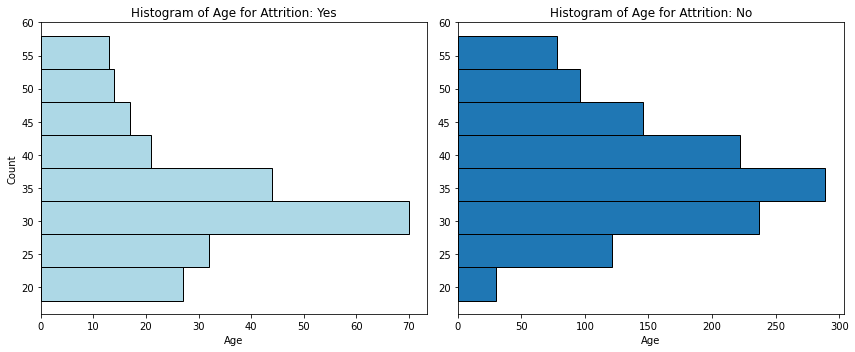

In [36]:
# Histogram of Age for Attrition
df_age = df.select("Age", "Attrition").toPandas()

bins = range(18, 60, 5)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# first subplot (Attrition: Yes)
counts1, edges1, _ = ax1.hist(df_age[df_age["Attrition"] == "Yes"]["Age"], bins=bins, orientation='horizontal', color='lightblue', edgecolor='black')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
ax1.set_title('Histogram of Age for Attrition: Yes')

# second subplot (Attrition: No)
counts2, edges2, _ = ax2.hist(df_age[df_age["Attrition"] == "No"]["Age"], bins=bins, orientation='horizontal', edgecolor='black')
ax2.set_xlabel('Age')
ax2.set_ylabel('')
ax2.set_title('Histogram of Age for Attrition: No')

plt.tight_layout()
plt.show()

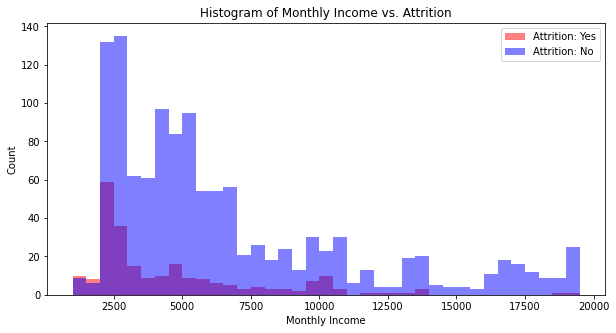

In [37]:
# Histogram of Monthly Income for Attrition
df_income = df.select("MonthlyIncome", "Attrition").toPandas()
plt.figure(figsize=(10, 5))
bins = range(1000, 20000, 500)
plt.hist(df_income[df_income["Attrition"] == "Yes"]["MonthlyIncome"], bins=bins, alpha=0.5, label='Attrition: Yes', color='red')
plt.hist(df_income[df_income["Attrition"] == "No"]["MonthlyIncome"], bins=bins, alpha=0.5, label='Attrition: No', color='blue')
plt.xlabel('Monthly Income')
plt.ylabel('Count')
plt.title('Histogram of Monthly Income vs. Attrition')
plt.legend()
plt.show()

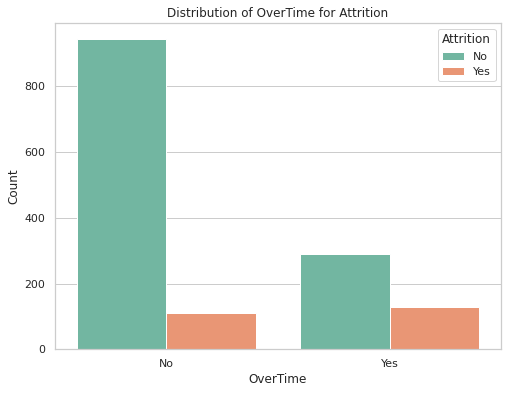

In [38]:
# Distribution of Over Time for Attrition
df_overtime = df.select("OverTime", "Attrition").toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=df_overtime, x="OverTime", hue="Attrition", palette="Set2", order=np.unique(df_overtime["OverTime"]),hue_order=np.unique(df_overtime["Attrition"]))
plt.xlabel("OverTime")
plt.ylabel("Count")
plt.title("Distribution of OverTime for Attrition")
plt.legend(title="Attrition", loc="upper right")
plt.show()

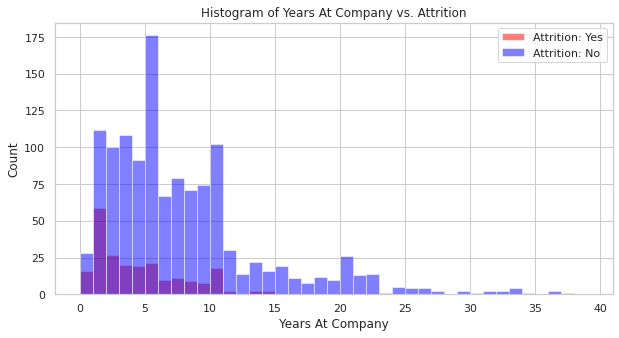

In [39]:
# Histogram of Years at Company for Attrition
df_years_at_company = df.select("YearsAtCompany", "Attrition").toPandas()
plt.figure(figsize=(10, 5))
bins = range(0, 40, 1)
plt.hist(df_years_at_company[df_years_at_company["Attrition"] == "Yes"]["YearsAtCompany"], bins=bins, alpha=0.5, label="Attrition: Yes", color="red")
plt.hist(df_years_at_company[df_years_at_company["Attrition"] == "No"]["YearsAtCompany"], bins=bins, alpha=0.5, label="Attrition: No", color="blue")
plt.xlabel("Years At Company")
plt.ylabel("Count")
plt.title("Histogram of Years At Company vs. Attrition")
plt.legend()
plt.show()

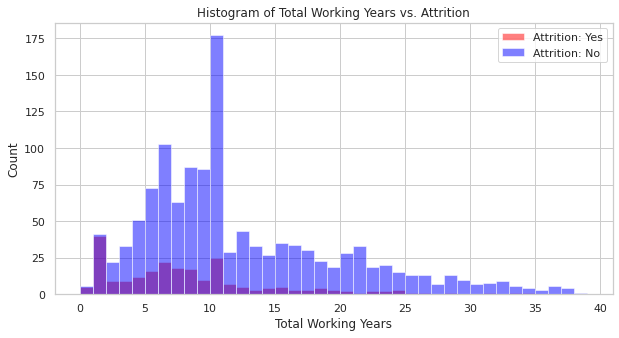

In [40]:
# Histogram of Total Working Years for Attrition
df_total_working_years = df.select("TotalWorkingYears", "Attrition").toPandas()
plt.figure(figsize=(10, 5))
bins = range(0, 40, 1)
total_working_years = df_total_working_years['TotalWorkingYears']
attrition = df_total_working_years['Attrition']
plt.hist(total_working_years[attrition == "Yes"], bins=bins, alpha=0.5, label="Attrition: Yes", color="red")
plt.hist(total_working_years[attrition == "No"], bins=bins, alpha=0.5, label="Attrition: No", color="blue")
plt.xlabel("Total Working Years")
plt.ylabel("Count")
plt.title("Histogram of Total Working Years vs. Attrition")
plt.legend()
plt.show()

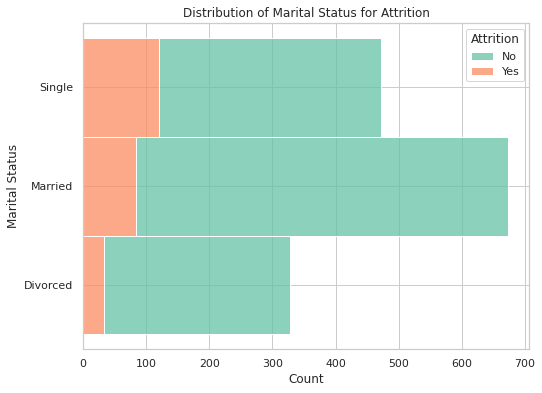

In [41]:
# Distribution of Marital Status for Attrition
df_marital_status = df.select("MaritalStatus", "Attrition").toPandas()
attrition = df_marital_status['Attrition']
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df_marital_status, y="MaritalStatus", hue="Attrition", palette="Set2", multiple="stack", bins=100, hue_order=np.unique(attrition))
plt.xlabel("Count")
plt.ylabel("Marital Status")
plt.title("Distribution of Marital Status for Attrition")
plt.show()

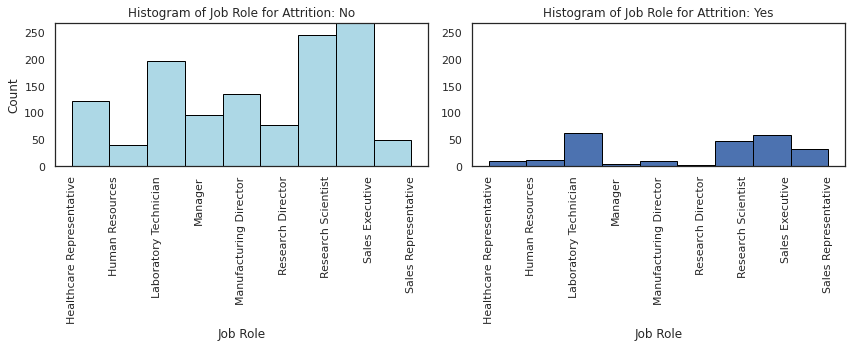

In [42]:
# Histogram of Job Role for Attrition
df_job_role = df.select("JobRole", "Attrition").toPandas()
sns.set_style("white")
unique_job_roles = sorted(df_job_role["JobRole"].unique())

# Create a mapping from original job roles to alphabetical order
job_role_to_alphabetical = {job: idx for idx, job in enumerate(unique_job_roles)}

# Sort the data by the alphabetical order of job roles
job_role_yes = df_job_role[df_job_role["Attrition"] == "Yes"]["JobRole"].map(job_role_to_alphabetical)
job_role_no = df_job_role[df_job_role["Attrition"] == "No"]["JobRole"].map(job_role_to_alphabetical)
max_count = max(job_role_yes.value_counts().max(), job_role_no.value_counts().max())

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
counts1, edges1, _ = plt.hist(job_role_no, bins=len(unique_job_roles), color="lightblue", edgecolor="black")
plt.xticks(range(len(unique_job_roles)), unique_job_roles, rotation=90)
plt.xlabel("Job Role")
plt.ylabel("Count")
plt.ylim(0, max_count)
plt.title("Histogram of Job Role for Attrition: No")

plt.subplot(1, 2, 2)
counts2, edges2, _ = plt.hist(job_role_yes, bins=len(unique_job_roles), edgecolor="black")
plt.xticks(range(len(unique_job_roles)), unique_job_roles, rotation=90)
plt.xlabel("Job Role")
plt.ylim(0, max_count)
plt.title("Histogram of Job Role for Attrition: Yes")

plt.tight_layout()
plt.show()

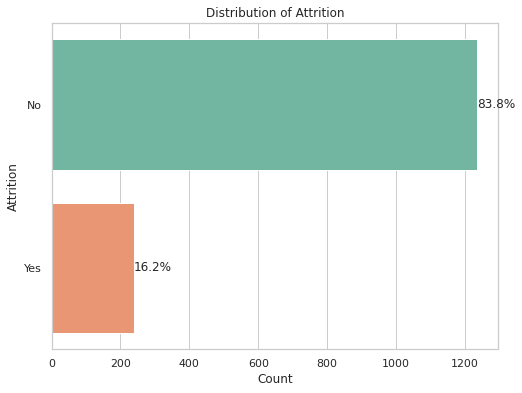

In [43]:
# Distribution of Attrition
df_attrition = df.select("Attrition").toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df_attrition, y="Attrition", palette="Set2", order=df_attrition["Attrition"].value_counts().index)
total = len(df_attrition)
for p in ax.patches:
    percentage = "{:.1f}%".format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), fontsize=12, va="center")

plt.xlabel("Count")
plt.ylabel("Attrition")
plt.title("Distribution of Attrition")
plt.show()

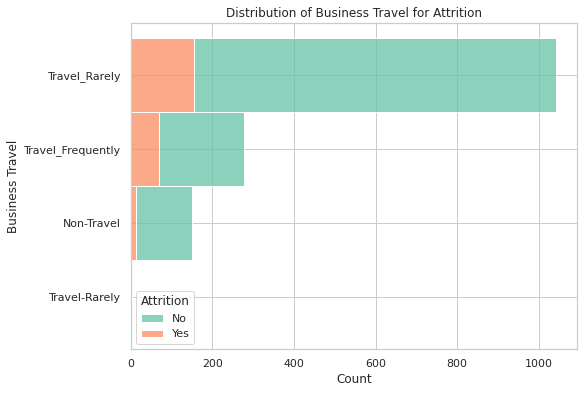

In [44]:
# Distribution of Business Travel for Attrition
df_business_travel = df.select("Attrition","BusinessTravel").toPandas()
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(data=df_business_travel, y="BusinessTravel", hue="Attrition", palette="Set2", multiple="stack", hue_order=np.unique(df_business_travel["Attrition"]))
plt.xlabel("Count")
plt.ylabel("Business Travel")
plt.title("Distribution of Business Travel for Attrition")
plt.show()

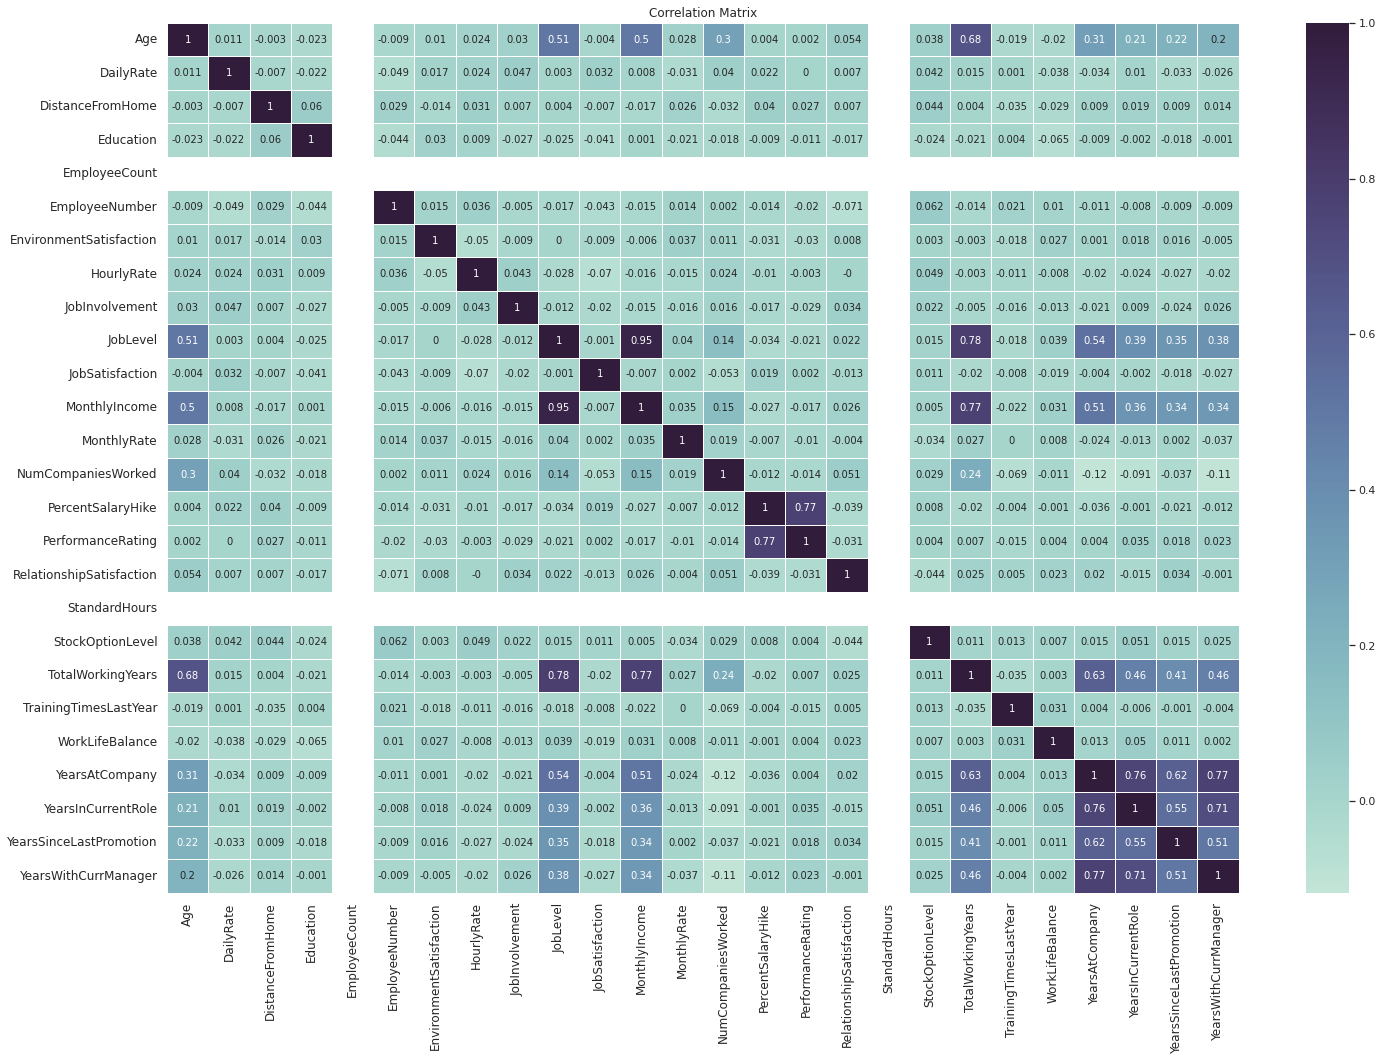

In [45]:
# Heatmap of Correlation Matrix
df_overview = df.toPandas()
sns.set(style="white")
df_corr = round(df_overview.corr().sort_index(axis = 0).sort_index(axis = 1), 3)
plt.figure(figsize = (24,16))
heatmap = sns.heatmap(df_corr, annot=True, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True), linewidths=.5, annot_kws = {"size": 10} )
heatmap.set_xticklabels(heatmap.get_xticklabels(), size=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), size=12)
plt.title("Correlation Matrix")
plt.show()

### Verify Data Quality

In [46]:
# Missing Data
missing_value_rows = df.filter((df["MonthlyIncome"].isNull()) | (df["MonthlyIncome"] == ""))
display(missing_value_rows)

EmployeeNumber,Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Over18,Attrition,BusinessTravel,DailyRate,Department,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
378,37,6,4,Medical,Male,Married,Y,No,Travel_Rarely,228,Sales,1,3,98,3,2,Sales Executive,4,null,22825,4,No,14,3,2,80,1,7,5,4,5,4,0,1


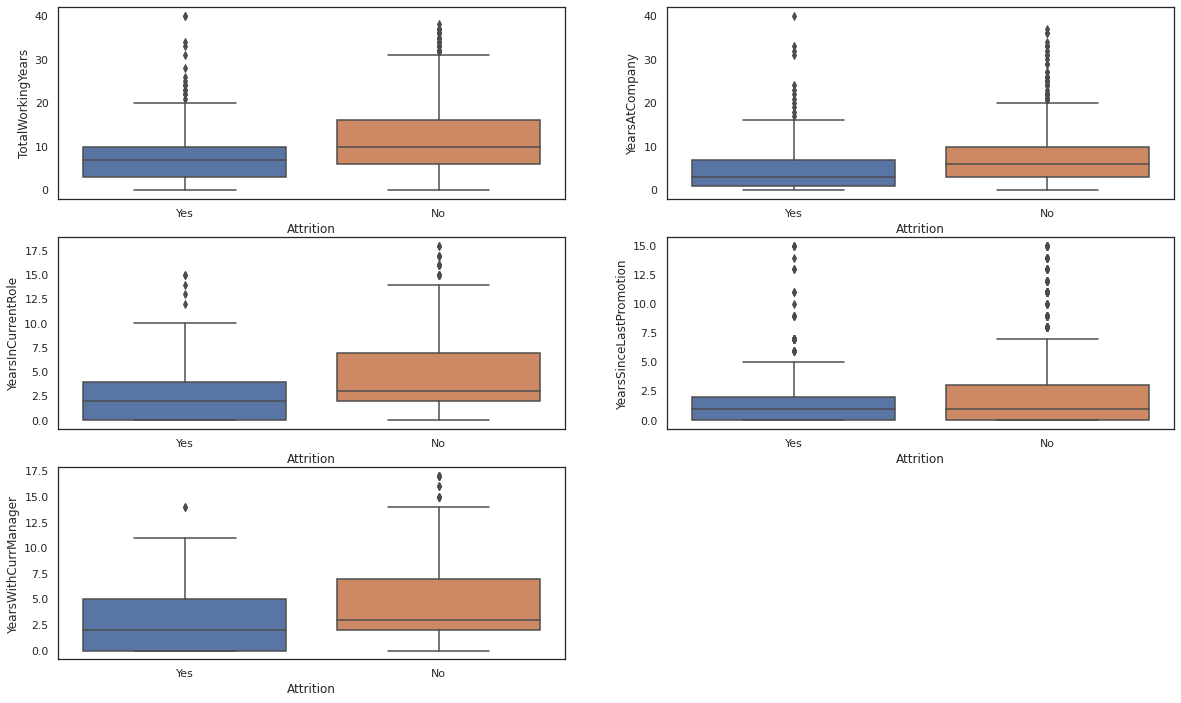

In [47]:
# Outliers and Extreme Values
# Boxplots for Outliers
df_outliers_extremes = df.select("Attrition", "TotalWorkingYears", "YearsAtCompany", "YearsInCurrentRole", "YearsSinceLastPromotion", "YearsWithCurrManager").toPandas()
sns.set(style='white')
plt.figure(figsize = (20,12))
plt.subplot(3, 2, 1)
sns.boxplot(x=df_outliers_extremes["Attrition"], y=df_outliers_extremes['TotalWorkingYears'], data=df_outliers_extremes)
plt.subplot(3, 2, 2)
sns.boxplot(x=df_outliers_extremes["Attrition"], y=df_outliers_extremes['YearsAtCompany'], data=df_outliers_extremes)
plt.subplot(3, 2, 3)
sns.boxplot(x=df_outliers_extremes["Attrition"], y=df_outliers_extremes['YearsInCurrentRole'], data=df_outliers_extremes)
plt.subplot(3, 2, 4)
sns.boxplot(x=df_outliers_extremes["Attrition"], y=df_outliers_extremes['YearsSinceLastPromotion'], data=df_outliers_extremes)
plt.subplot(3, 2, 5)
sns.boxplot(x=df_outliers_extremes["Attrition"], y=df_outliers_extremes['YearsWithCurrManager'], data=df_outliers_extremes)
plt.show()

In [48]:
# Extremes in “Education”
education_allowed_values = [1, 2, 3, 4, 5]
df_extremes = df.filter(~df["Education"].isin(education_allowed_values))
display(df_extremes)

EmployeeNumber,Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Over18,Attrition,BusinessTravel,DailyRate,Department,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
2069,35,1,-1,Life Sciences,Female,Single,Y,Yes,Travel_Rarely,1102,Sales,1,2,94,3,2,Sales Executive,4,5993,19479,8,Yes,11,3,1,80,0,8,0,1,6,4,0,5
3,29,28,1001221,Medical,Female,Single,Y,No,Travel_Rarely,468,Research & Develo...,1,4,73,2,1,Research Scientist,1,6700,8489,1,No,14,3,2,80,0,5,3,1,5,4,0,4


## Data Preparation

### Select Data

In [49]:
# number of columns in original dataset
len(df.columns)

35

In [50]:
# number of columns after selecting

columns_to_remove = ["EmployeeCount", "EmployeeNumber", "StandardHours", "Over18", "HourlyRate", "DailyRate", "MonthlyRate"]

columns_to_keep = [col for col in df.columns if col not in columns_to_remove]
df_select = df.select(columns_to_keep)

len(df_select.columns)

28

### Clean Data

In [51]:
# Remove Extreme Values In Education
education_allowed_values = [1, 2, 3, 4, 5]
df_clean = df_select.filter(df_select["Education"].isin(education_allowed_values))
df_clean.filter(~df_clean["Education"].isin(education_allowed_values)).show() # no extremes values in education after cleaning

+---+----------------+---------+--------------+------+-------------+---------+--------------+----------+-----------------------+--------------+--------+-------+---------------+-------------+------------------+--------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|DistanceFromHome|Education|EducationField|Gender|MaritalStatus|Attrition|BusinessTravel|Department|EnvironmentSatisfaction|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MonthlyIncome|NumCompaniesWorked|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+----------------+---------+--------------+------+-------------+---------+--------------+----------+-----------------------+--------

In [52]:
# unique values of BusinessTravel in original dataset
df.select("BusinessTravel").distinct()

BusinessTravel
Travel_Frequently
Travel-Rarely
Non-Travel
Travel_Rarely


In [53]:
# Fix code consistency in BusinessTravel
df_clean = df_clean.withColumn("BusinessTravel", when(col("BusinessTravel") == "Travel-Rarely", "Travel_Rarely").otherwise(col("BusinessTravel")))
df_clean.select("BusinessTravel").distinct()

BusinessTravel
Travel_Frequently
Non-Travel
Travel_Rarely


In [54]:
# Missing Monthly Income Value in Original Dataset
display(df.filter((df["MonthlyIncome"].isNull()) | (df["MonthlyIncome"] == "")))

EmployeeNumber,Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Over18,Attrition,BusinessTravel,DailyRate,Department,EmployeeCount,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
378,37,6,4,Medical,Male,Married,Y,No,Travel_Rarely,228,Sales,1,3,98,3,2,Sales Executive,4,null,22825,4,No,14,3,2,80,1,7,5,4,5,4,0,1


In [55]:
# Replace Missing Monthly Income Value with Median
median_income = df_clean.selectExpr("percentile_approx(MonthlyIncome, 0.5) as median").collect()[0]["median"]
df_clean = df_clean.withColumn("MonthlyIncome", when((col("MonthlyIncome").isNull()) | (col("MonthlyIncome") == ""), median_income).otherwise(col("MonthlyIncome")))

# No missing value after cleaning
display(df_clean.filter((df_clean["MonthlyIncome"].isNull()) | (df_clean["MonthlyIncome"] == "")))

Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Attrition,BusinessTravel,Department,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


In [56]:
# show the updated data
display(df_clean.filter((df["MonthlyIncome"].isNull()) | (df["MonthlyIncome"] == "")))

Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Attrition,BusinessTravel,Department,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
37,6,4,Medical,Male,Married,No,Travel_Rarely,Sales,3,3,2,Sales Executive,4,4908,4,No,14,3,2,1,7,5,4,5,4,0,1


In [57]:
def median_imputation(data,columns_with_outliers_extremes,outlier_threshold,extreme_threshold):
    for column in columns_with_outliers_extremes:
        median_expr = expr(f"percentile_approx({column}, 0.5) as median")
        std_dev_expr = expr(f"stddev({column}) as std_dev")
        quartiles = data.select(median_expr, std_dev_expr).collect()[0]
        median = quartiles.median
        std_dev = quartiles.std_dev

        upper_limit_outlier = median + outlier_threshold * std_dev
        lower_limit_outlier = median - outlier_threshold * std_dev
    
        upper_limit_extreme = median + extreme_threshold * std_dev
        lower_limit_extreme = median - extreme_threshold * std_dev
    
        data = data.withColumn(column, when((col(column) > upper_limit_outlier) | (col(column) < lower_limit_outlier), median).otherwise(col(column)))
        data = data.withColumn(column, when((col(column) > upper_limit_extreme) | (col(column) < lower_limit_extreme), median).otherwise(col(column)))

    return data

columns_with_outliers_extremes = ['TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

# First time for median imputation
df_clean = median_imputation(df_clean,columns_with_outliers_extremes,outlier_threshold,extreme_threshold)

results_df = count_outliers_extremes_missing_values(df_clean,outlier_threshold,extreme_threshold)
display(results_df)

,Variable,Valid Records,Outliers,Extremes,Missing Values
0,Age,1470,0,0,0
1,DistanceFromHome,1470,0,0,0
2,Education,1470,0,0,0
3,EducationField,1470,0,0,0
4,Gender,1470,0,0,0
5,MaritalStatus,1470,0,0,0
6,Attrition,1470,0,0,0
7,BusinessTravel,1470,0,0,0
8,Department,1470,0,0,0
9,EnvironmentSatisfaction,1470,0,0,0


In [58]:
columns_with_outliers_extremes = ['TotalWorkingYears', 'YearsAtCompany', 'YearsSinceLastPromotion']

# Second time for median imputation
df_clean = median_imputation(df_clean,columns_with_outliers_extremes,outlier_threshold,extreme_threshold)

results_df = count_outliers_extremes_missing_values(df_clean,outlier_threshold,extreme_threshold)
display(results_df)

,Variable,Valid Records,Outliers,Extremes,Missing Values
0,Age,1470,0,0,0
1,DistanceFromHome,1470,0,0,0
2,Education,1470,0,0,0
3,EducationField,1470,0,0,0
4,Gender,1470,0,0,0
5,MaritalStatus,1470,0,0,0
6,Attrition,1470,0,0,0
7,BusinessTravel,1470,0,0,0
8,Department,1470,0,0,0
9,EnvironmentSatisfaction,1470,0,0,0


In [59]:
columns_with_outliers_extremes = ['YearsAtCompany']

# Third time for median imputation
df_clean = median_imputation(df_clean,columns_with_outliers_extremes,outlier_threshold,extreme_threshold)

results_df = count_outliers_extremes_missing_values(df_clean,outlier_threshold,extreme_threshold)
display(results_df)

,Variable,Valid Records,Outliers,Extremes,Missing Values
0,Age,1470,0,0,0
1,DistanceFromHome,1470,0,0,0
2,Education,1470,0,0,0
3,EducationField,1470,0,0,0
4,Gender,1470,0,0,0
5,MaritalStatus,1470,0,0,0
6,Attrition,1470,0,0,0
7,BusinessTravel,1470,0,0,0
8,Department,1470,0,0,0
9,EnvironmentSatisfaction,1470,0,0,0


In [60]:
columns_with_outliers_extremes = ['YearsAtCompany']

# Fourth time for median imputation
df_clean = median_imputation(df_clean,columns_with_outliers_extremes,outlier_threshold,extreme_threshold)

results_df = count_outliers_extremes_missing_values(df_clean,outlier_threshold,extreme_threshold)
display(results_df)

23/10/10 09:14:46 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at o

23/10/10 09:14:54 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at o

23/10/10 09:15:03 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at o

23/10/10 09:15:10 ERROR CodeGenerator: failed to compile: org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
org.codehaus.janino.InternalCompilerException: Compiling "GeneratedClass" in "generated.java": Code of method "agg_doAggregateWithoutKey_0$(Lorg/apache/spark/sql/catalyst/expressions/GeneratedClass$GeneratedIteratorForCodegenStage2;)V" of class "org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2" grows beyond 64 KB
	at org.codehaus.janino.UnitCompiler.compile2(UnitCompiler.java:366)
	at org.codehaus.janino.UnitCompiler.access$000(UnitCompiler.java:226)
	at org.codehaus.janino.UnitCompiler$1.visitCompilationUnit(UnitCompiler.java:336)
	at o

,Variable,Valid Records,Outliers,Extremes,Missing Values
0,Age,1470,0,0,0
1,DistanceFromHome,1470,0,0,0
2,Education,1470,0,0,0
3,EducationField,1470,0,0,0
4,Gender,1470,0,0,0
5,MaritalStatus,1470,0,0,0
6,Attrition,1470,0,0,0
7,BusinessTravel,1470,0,0,0
8,Department,1470,0,0,0
9,EnvironmentSatisfaction,1470,0,0,0


### Construct Data

In [61]:
# Age Group
age_splits = [0, 25, 35, 50, float("inf")]
age_bucketizer = Bucketizer(splits=age_splits, inputCol="Age", outputCol="AgeGroup")
df_construct = age_bucketizer.transform(df_clean)
df_construct = df_construct.withColumn("AgeRange",lit(""))
age_groups = ["Youth", "Adult", "Middle", "Senior"]
age_ranges = ["0-25", "26-35", "36-50", "50+"]
for i, group in enumerate(age_groups):
    age_range = age_ranges[i]
    df_construct = df_construct.withColumn("AgeGroup", when(col("AgeGroup") == i, group).otherwise(col("AgeGroup")))
    df_construct = df_construct.withColumn("AgeRange", when(col("AgeGroup") == group, age_range).otherwise(col("AgeRange")))

display(df_construct.select("AgeGroup", "AgeRange").distinct())
df_construct = df_construct.drop("AgeRange")

# Income Group
income_discretizer = QuantileDiscretizer(numBuckets=4, inputCol="MonthlyIncome", outputCol="IncomeGroup", relativeError=0.01)
income_discretizer_model = income_discretizer.fit(df_construct)
df_construct = income_discretizer_model.transform(df_construct)
income_splits = income_discretizer_model.getSplits()
df_construct = df_construct.withColumn("IncomeRange",lit(""))
income_groups = ["Below Average", "Average", "Above Average", "High"]
max_income = df_construct.agg(F.max("MonthlyIncome")).collect()[0][0]
income_ranges = [f"{0}-{income_splits[1]}",f"{income_splits[1]}-{income_splits[2]}",f"{income_splits[2]}-{income_splits[3]}", f"{income_splits[3]}-{max_income}"]
for i, group in enumerate(income_groups):
    income_range = income_ranges[i]
    df_construct = df_construct.withColumn("IncomeGroup", when(col("IncomeGroup") == i, group).otherwise(col("IncomeGroup")))
    df_construct = df_construct.withColumn("IncomeRange", when(col("IncomeGroup") == group, income_range).otherwise(col("IncomeRange")))

display(df_construct.select("IncomeGroup", "IncomeRange").distinct())
df_construct = df_construct.drop("IncomeRange")

display(df_construct)

AgeGroup,AgeRange
Middle,36-50
Senior,50+
Youth,0-25
Adult,26-35


IncomeGroup,IncomeRange
Below Average,0-2867.0
High,8020.0-19999
Above Average,4855.0-8020.0
Average,2867.0-4855.0


Age,DistanceFromHome,Education,EducationField,Gender,MaritalStatus,Attrition,BusinessTravel,Department,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AgeGroup,IncomeGroup
41,1,2,Life Sciences,Female,Single,Yes,Travel_Rarely,Sales,2,3,2,Sales Executive,4,5993,8,Yes,11,3,1,0,8,0,1,6,4,0,5,Middle,Above Average
49,8,1,Life Sciences,Male,Married,No,Travel_Frequently,Research & Develo...,3,2,2,Research Scientist,2,5130,1,No,23,4,4,1,10,3,3,10,7,1,7,Middle,Above Average
37,2,2,Other,Male,Single,Yes,Travel_Rarely,Research & Develo...,4,2,1,Laboratory Techni...,3,2090,6,Yes,15,3,2,0,7,3,3,0,0,0,0,Middle,Below Average
33,3,4,Life Sciences,Female,Married,No,Travel_Frequently,Research & Develo...,4,3,1,Research Scientist,3,2909,1,Yes,11,3,3,0,8,3,3,8,7,3,0,Adult,Average
27,2,1,Medical,Male,Married,No,Travel_Rarely,Research & Develo...,1,3,1,Laboratory Techni...,2,3468,9,No,12,3,4,1,6,3,3,2,2,2,2,Adult,Average
32,2,2,Life Sciences,Male,Single,No,Travel_Frequently,Research & Develo...,4,3,1,Laboratory Techni...,4,3068,0,No,13,3,3,0,8,2,2,7,7,3,6,Adult,Average
59,3,3,Medical,Female,Married,No,Travel_Rarely,Research & Develo...,3,4,1,Laboratory Techni...,1,2670,4,Yes,20,4,1,3,12,3,2,1,0,0,0,Senior,Below Average
30,24,1,Life Sciences,Male,Divorced,No,Travel_Rarely,Research & Develo...,4,3,1,Laboratory Techni...,3,2693,1,No,22,4,2,1,1,2,3,1,0,0,0,Adult,Below Average
38,23,3,Life Sciences,Male,Single,No,Travel_Frequently,Research & Develo...,4,2,3,Manufacturing Dir...,3,9526,0,No,21,4,2,0,10,2,3,9,7,1,8,Middle,High
36,27,3,Medical,Male,Married,No,Travel_Rarely,Research & Develo...,3,3,2,Healthcare Repres...,3,5237,6,No,13,3,2,2,17,3,2,7,7,7,7,Middle,Above Average


### Format Data as Required

In [62]:
# convert categorical data to numeric data for computing statistics
columns_to_convert = ["EducationField", "Gender", "MaritalStatus","Attrition", "BusinessTravel", "Department", "JobRole", "OverTime", "AgeGroup", "IncomeGroup"]

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="skip")
            for col_name in columns_to_convert]
stages = indexers

pipeline = Pipeline(stages=stages)

model = pipeline.fit(df_construct)

df_construct = model.transform(df_construct)

for col_name in columns_to_convert:
    df_construct = df_construct.drop(col_name)
    df_construct = df_construct.withColumnRenamed(col_name + "_index", col_name)

In [63]:
df_construct.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsInCurrentRole: integer (nullable = true)
 |-- YearsSinceLastPromotion: integer (nullable = true)
 |-- YearsWithCurrManager: integer (nullable = true)
 |-- Education

## Data Transformation

### Reduce Data

In [64]:
# First feature selection -- select the top-29 features based on the chi-squared test
df_transformation = df_construct

feature_columns = [col_name for col_name in df_transformation.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_transformation = assembler.transform(df_transformation)

pandas_df = df_transformation.select("Attrition", "features").toPandas()

X = pandas_df["features"]
y = pandas_df["Attrition"]

X = np.vstack(X.apply(lambda x: x.toArray()))

k_best = SelectKBest(score_func=chi2, k=29)
X_transform = k_best.fit_transform(X, y)

selected_indices = (-k_best.scores_).argsort()[:29]
selected_features = [feature_columns[i] for i in selected_indices]
selected_scores = k_best.scores_[selected_indices]
selected_rankings = range(1, 30)

selected_feature_info_df_first = pd.DataFrame({"Feature": selected_features,
                                              "Score": selected_scores,
                                              "Ranking": selected_rankings})

print("Selected Features Information:")
print(selected_feature_info_df_first)

Selected Features Information:
                     Feature          Score  Ranking
0              MonthlyIncome  127781.966825        1
1          TotalWorkingYears     218.263510        2
2         YearsInCurrentRole     103.736578        3
3       YearsWithCurrManager     102.913017        4
4             YearsAtCompany      99.284230        5
5                        Age      84.155277        6
6                   OverTime      63.845067        7
7           DistanceFromHome      63.772142        8
8                IncomeGroup      42.520581        9
9                   AgeGroup      39.718425       10
10          StockOptionLevel      25.268826       11
11                  JobLevel      24.939242       12
12            EducationField       8.499758       13
13                Department       7.310314       14
14           JobSatisfaction       7.011947       15
15   EnvironmentSatisfaction       6.890594       16
16        NumCompaniesWorked       6.438654       17
17            J

In [65]:
df_transformation = df_transformation.drop("features")

In [66]:
columns_to_remove_transformation_first = ["AgeGroup", "IncomeGroup"]

for column in columns_to_remove_transformation_first:
    df_transformation = df_transformation.drop(column)

df_transformation.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsInCurrentRole: integer (nullable = true)
 |-- YearsSinceLastPromotion: integer (nullable = true)
 |-- YearsWithCurrManager: integer (nullable = true)
 |-- Education

In [67]:
# balancing data
majority_class = df_transformation.filter(col("Attrition") == 0)
minority_class = df_transformation.filter(col("Attrition") == 1)

minority_count = minority_class.count()
majority_count = majority_class.count()
balance_ratio = int(majority_count / minority_count)

oversampled_minority_class = minority_class
for _ in range(balance_ratio - 1):
    oversampled_minority_class = oversampled_minority_class.union(minority_class)

df_balanced = majority_class.union(oversampled_minority_class)

display(df_balanced)

23/10/10 09:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1179.8 KiB
23/10/10 09:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1179.8 KiB


Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EducationField,Gender,MaritalStatus,Attrition,BusinessTravel,Department,JobRole,OverTime
49,8,1,3,2,2,2,5130,1,23,4,4,1,10,3,3,10,7,1,7,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
33,3,4,4,3,1,3,2909,1,11,3,3,0,8,3,3,8,7,3,0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
27,2,1,1,3,1,2,3468,9,12,3,4,1,6,3,3,2,2,2,2,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
32,2,2,4,3,1,4,3068,0,13,3,3,0,8,2,2,7,7,3,6,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0
59,3,3,3,4,1,1,2670,4,20,4,1,3,12,3,2,1,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
30,24,1,4,3,1,3,2693,1,22,4,2,1,1,2,3,1,0,0,0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
38,23,3,4,2,3,3,9526,0,21,4,2,0,10,2,3,9,7,1,8,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0
36,27,3,3,3,2,3,5237,6,13,3,2,2,17,3,2,7,7,7,7,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
35,16,3,1,4,1,2,2426,0,13,3,3,1,6,5,3,5,4,0,3,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
29,15,2,4,2,2,3,4193,0,12,3,4,0,10,3,3,9,5,0,8,0.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0


In [68]:
df_balanced.count()

2418

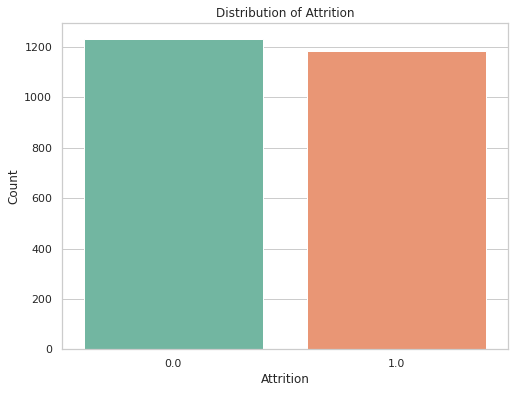

In [69]:
distribution_data = df_balanced.groupBy('Attrition').count().toPandas()

sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))
sns.barplot(data=distribution_data, x='Attrition', y='count', palette='Set2')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.title('Distribution of Attrition')
plt.show()

In [70]:
# Second feature selection
feature_columns = [col_name for col_name in df_balanced.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_balanced = assembler.transform(df_balanced)

pandas_df = df_balanced.select("Attrition", "features").toPandas()

X = pandas_df["features"]
y = pandas_df["Attrition"]

X = np.vstack(X.apply(lambda x: x.toArray()))

k_best = SelectKBest(score_func=chi2, k=27)
X_transform = k_best.fit_transform(X, y)

selected_indices = (-k_best.scores_).argsort()[:27]
selected_features = [feature_columns[i] for i in selected_indices]
selected_scores = k_best.scores_[selected_indices]
selected_rankings = range(1, 28)

selected_feature_info_df_first = pd.DataFrame({"Feature": selected_features,
                                              "Score": selected_scores,
                                              "Ranking": selected_rankings})

print("Selected Features Information:")
print(selected_feature_info_df_first)

23/10/10 09:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB


Selected Features Information:
                     Feature          Score  Ranking
0              MonthlyIncome  433213.005395        1
1          TotalWorkingYears     741.724952        2
2         YearsInCurrentRole     358.066445        3
3       YearsWithCurrManager     355.036491        4
4             YearsAtCompany     334.959167        5
5                        Age     265.143149        6
6           DistanceFromHome     182.628947        7
7                   OverTime     143.720497        8
8           StockOptionLevel      88.448470        9
9                   JobLevel      82.496360       10
10            EducationField      24.274457       11
11           JobSatisfaction      22.142118       12
12   EnvironmentSatisfaction      21.752618       13
13                Department      20.180982       14
14        NumCompaniesWorked      18.890346       15
15            JobInvolvement      14.437070       16
16     TrainingTimesLastYear       9.615365       17
17             

In [71]:
columns_to_remove_transformation_second = ["PercentSalaryHike", "MaritalStatus", "PerformanceRating", "BusinessTravel"]

for column in columns_to_remove_transformation_second:
    df_balanced = df_balanced.drop(column)

df_balanced.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsInCurrentRole: integer (nullable = true)
 |-- YearsSinceLastPromotion: integer (nullable = true)
 |-- YearsWithCurrManager: integer (nullable = true)
 |-- EducationField: double (nullable = false)
 |-- Gender: double (nullable = false)
 |-- Attrition: double (null

In [72]:
df_balanced = df_balanced.drop("features")

### Project Data

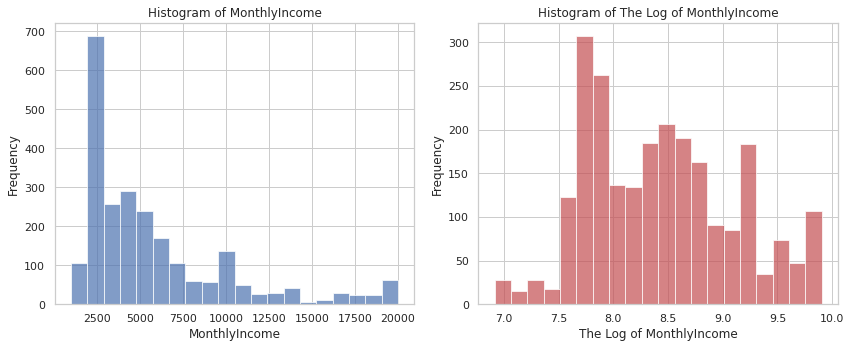

In [73]:
# Transform of Monthly Income
monthly_income_col = 'MonthlyIncome'

df_balanced_log = df_balanced.withColumn("log_monthly_income", log(col(monthly_income_col)))

pandas_df = df_balanced_log.select(monthly_income_col, "log_monthly_income").toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.hist(pandas_df[monthly_income_col], bins=20, color='b', alpha=0.7)
ax1.set_xlabel('MonthlyIncome')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of MonthlyIncome')

ax2.hist(pandas_df['log_monthly_income'], bins=20, color='r', alpha=0.7)
ax2.set_xlabel('The Log of MonthlyIncome')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of The Log of MonthlyIncome')

plt.tight_layout()
plt.show()

## Data-mining Algorithm(s) Selection

In [74]:
# feature selection
df_dma = df_balanced

feature_columns = [col_name for col_name in df_dma.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dma = assembler.transform(df_dma)

pandas_df = df_dma.select("Attrition", "features").toPandas()

X = pandas_df["features"]
y = pandas_df["Attrition"]

X = np.vstack(X.apply(lambda x: x.toArray()))

k_best = SelectKBest(score_func=chi2, k=23)
X_transform = k_best.fit_transform(X, y)

selected_indices = (-k_best.scores_).argsort()[:23]
selected_features = [feature_columns[i] for i in selected_indices]
selected_scores = k_best.scores_[selected_indices]
selected_rankings = range(1, 24)

selected_feature_info_df_first = pd.DataFrame({"Feature": selected_features,
                                              "Score": selected_scores,
                                              "Ranking": selected_rankings})

print("Selected Features Information:")
print(selected_feature_info_df_first)

23/10/10 09:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1143.6 KiB


Selected Features Information:
                     Feature          Score  Ranking
0              MonthlyIncome  433213.005395        1
1          TotalWorkingYears     741.724952        2
2         YearsInCurrentRole     358.066445        3
3       YearsWithCurrManager     355.036491        4
4             YearsAtCompany     334.959167        5
5                        Age     265.143149        6
6           DistanceFromHome     182.628947        7
7                   OverTime     143.720497        8
8           StockOptionLevel      88.448470        9
9                   JobLevel      82.496360       10
10            EducationField      24.274457       11
11           JobSatisfaction      22.142118       12
12   EnvironmentSatisfaction      21.752618       13
13                Department      20.180982       14
14        NumCompaniesWorked      18.890346       15
15            JobInvolvement      14.437070       16
16     TrainingTimesLastYear       9.615365       17
17             

In [75]:
df_dma = df_dma.drop("features")

In [76]:
# save temporary dataset
df_dma.write.parquet(os.getcwd() + '/temporary_dataset/df_dma.parquet', mode="overwrite")

23/10/10 09:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1265.4 KiB


In [31]:
# df_dma = spark.read.parquet(os.getcwd() + '/temporary_dataset/df_dma.parquet')
# display(df_dma)

Age,DistanceFromHome,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,EducationField,Gender,Attrition,Department,JobRole,OverTime
49,8,1,3,2,2,2,5130,1,4,1,10,3,3,10,7,1,7,0.0,0.0,0.0,0.0,1.0,0.0
33,3,4,4,3,1,3,2909,1,3,0,8,3,3,8,7,3,0,0.0,1.0,0.0,0.0,1.0,1.0
27,2,1,1,3,1,2,3468,9,4,1,6,3,3,2,2,2,2,1.0,0.0,0.0,0.0,2.0,0.0
32,2,2,4,3,1,4,3068,0,3,0,8,2,2,7,7,3,6,0.0,0.0,0.0,0.0,2.0,0.0
59,3,3,3,4,1,1,2670,4,1,3,12,3,2,1,0,0,0,1.0,1.0,0.0,0.0,2.0,1.0
30,24,1,4,3,1,3,2693,1,2,1,1,2,3,1,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
38,23,3,4,2,3,3,9526,0,2,0,10,2,3,9,7,1,8,0.0,0.0,0.0,0.0,3.0,0.0
36,27,3,3,3,2,3,5237,6,2,2,17,3,2,7,7,7,7,1.0,0.0,0.0,0.0,4.0,0.0
35,16,3,1,4,1,2,2426,0,3,1,6,5,3,5,4,0,3,1.0,0.0,0.0,0.0,2.0,0.0
29,15,2,4,2,2,3,4193,0,4,0,10,3,3,9,5,0,8,0.0,1.0,0.0,0.0,2.0,1.0


In [32]:
#CART
feature_columns = [col_name for col_name in df_dma.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dma_model = assembler.transform(df_dma)

# Split the dataset into train and test
(train_data, test_data) = df_dma_model.randomSplit([0.7, 0.3], seed=42)

dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", seed=42)

model = dt_classifier.fit(train_data)

predictions = model.transform(test_data)

feature_importance = model.featureImportances

feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance.toArray())),columns=["Feature", "Importance"])

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Ranked Feature Importance:")
print(feature_importance_df)

Ranked Feature Importance:
                     Feature  Importance
22                  OverTime    0.234397
21                   JobRole    0.182405
11         TotalWorkingYears    0.101092
10          StockOptionLevel    0.083870
7              MonthlyIncome    0.075732
1           DistanceFromHome    0.065650
3    EnvironmentSatisfaction    0.062695
8         NumCompaniesWorked    0.060368
0                        Age    0.048711
6            JobSatisfaction    0.032094
16   YearsSinceLastPromotion    0.023778
18            EducationField    0.013911
15        YearsInCurrentRole    0.010142
2                  Education    0.005155
9   RelationshipSatisfaction    0.000000
5                   JobLevel    0.000000
12     TrainingTimesLastYear    0.000000
4             JobInvolvement    0.000000
14            YearsAtCompany    0.000000
17      YearsWithCurrManager    0.000000
19                    Gender    0.000000
20                Department    0.000000
13           WorkLifeBalance  

In [33]:
# evaluate the model

# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Attrition", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
conf_matrix = predictions.groupBy("Attrition", "prediction").count()
print("Confusion Matrix:")
conf_matrix.show()

# ROC curve
evaluator = BinaryClassificationEvaluator(labelCol="Attrition", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC: {area_under_roc}")

Accuracy: 0.7510917030567685
Confusion Matrix:
+---------+----------+-----+
|Attrition|prediction|count|
+---------+----------+-----+
|      1.0|       1.0|  249|
|      0.0|       1.0|   66|
|      1.0|       0.0|  105|
|      0.0|       0.0|  267|
+---------+----------+-----+

Area under ROC: 0.6829244498736025


In [34]:
tree = model.toDebugString

dot = Digraph(format='png')
lines = tree.split('\n')

def parse_tree_lines(lines, parent_node=None):
    for line in lines:
        if line.strip():
            if "DecisionTreeClassificationModel" in line:
                node_id = "Root"
                node_label = "Root"
            else:
                parts = line.strip().split(" ")
                node_id = parts[0].strip()
                node_label = " ".join(parts[1:]).strip()
            
            dot.node(node_id, label=node_label)
            
            if parent_node is not None:
                dot.edge(parent_node, node_id)
            
            if "->" in node_label:
                child_node_info = node_label.split("->")[1].strip()
                parse_tree_lines([child_node_info], node_id)

parse_tree_lines(lines)

In [35]:
def parse_debug_string_lines(lines):
    block = []
    while lines:
        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})
            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block

def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break
    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    return json

In [36]:
dict_tree_json = debug_str_to_json(tree)
f_type_to_flist_dict = df_dma_model.schema['features'].metadata["ml_attr"]["attrs"]

f_index_to_name_dict = {}

for f_type, f_list in f_type_to_flist_dict.items():
    for f in f_list:
        f_index = f['idx']
        f_name = f['name']
        f_index_to_name_dict[f_index] = f_name

In [37]:
# Replace this with the JSON representation of the decision tree
json_tree = dict_tree_json

def json_to_tree(json_data, parent=None):
    node_name = json_data["name"]
    
    # Extract feature index from the beginning of the node name
    feature_index_match = re.match(r'^feature (\d+) ', node_name)
    if feature_index_match:
        feature_index = int(feature_index_match.group(1))
        if feature_index in f_index_to_name_dict:
            feature_name = f_index_to_name_dict[feature_index]
            node_name = node_name.replace(f"feature {feature_index}", feature_name)
    node = Node(node_name, parent=parent)
    if "children" in json_data:
        for child in json_data["children"]:
            json_to_tree(child, parent=node)
    return node

root = json_to_tree(json_tree)

# Visualize the tree
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")

from anytree.exporter import UniqueDotExporter
UniqueDotExporter(root).to_picture(os.getcwd()+"/decision_tree_image/decision_tree.png")


Root
├── OverTime in {0.0}
│   ├── TotalWorkingYears <= 2.5
│   │   ├── JobRole in {1.0}
│   │   │   ├── DistanceFromHome <= 7.5
│   │   │   │   └── Predict: 0.0
│   │   │   └── DistanceFromHome > 7.5
│   │   │       ├── EducationField in {1.0}
│   │   │       │   └── Predict: 0.0
│   │   │       └── EducationField not in {1.0}
│   │   │           └── Predict: 1.0
│   │   └── JobRole not in {1.0}
│   │       ├── Age <= 34.5
│   │       │   ├── StockOptionLevel <= 2.5
│   │       │   │   └── Predict: 1.0
│   │       │   └── StockOptionLevel > 2.5
│   │       │       └── Predict: 0.0
│   │       └── Age > 34.5
│   │           └── Predict: 0.0
│   └── TotalWorkingYears > 2.5
│       ├── NumCompaniesWorked <= 4.5
│       │   ├── JobSatisfaction <= 1.5
│       │   │   ├── StockOptionLevel <= 0.5
│       │   │   │   └── Predict: 1.0
│       │   │   └── StockOptionLevel > 0.5
│       │   │       └── Predict: 0.0
│       │   └── JobSatisfaction > 1.5
│       │       └── Predict: 0.0
│       └─

In [38]:
df_dma = df_dma.drop("features")

In [39]:
# logistic Regression
feature_columns = [col_name for col_name in df_dma.columns if col_name != "Attrition"]
assembler_lr = VectorAssembler(inputCols=feature_columns, outputCol="features_lr")
df_dma_model_lr = assembler_lr.transform(df_dma)
(train_data_lr, test_data_lr) = df_dma_model_lr.randomSplit([0.7, 0.3], seed=42)
lr = LogisticRegression(featuresCol="features_lr", labelCol="Attrition")
model_lr = lr.fit(train_data_lr)
predictions_lr = model_lr.transform(test_data_lr)

23/10/10 10:53:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/10/10 10:53:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [40]:
# evaluate the model

# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Attrition", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_lr)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
conf_matrix = predictions_lr.groupBy("Attrition", "prediction").count()
print("Confusion Matrix:")
conf_matrix.show()

# ROC curve
evaluator = BinaryClassificationEvaluator(labelCol="Attrition", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions_lr)
print(f"Area under ROC: {area_under_roc}")

Accuracy: 0.7627365356622998
Confusion Matrix:
+---------+----------+-----+
|Attrition|prediction|count|
+---------+----------+-----+
|      1.0|       1.0|  259|
|      0.0|       1.0|   68|
|      1.0|       0.0|   95|
|      0.0|       0.0|  265|
+---------+----------+-----+

Area under ROC: 0.8366502095315639


In [41]:
# random forest
assembler_rf = VectorAssembler(inputCols=feature_columns, outputCol="features_rf")
df_dma_model_rf = assembler_rf.transform(df_dma)
(train_data_rf, test_data_rf) = df_dma_model_rf.randomSplit([0.7, 0.3], seed=42)
rf = RandomForestClassifier(featuresCol="features_rf", labelCol="Attrition", numTrees=100, seed=42)
model_rf = rf.fit(train_data_rf)
predictions_rf = model_rf.transform(test_data_rf)

In [42]:
# evaluate the model

# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Attrition", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_rf)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
conf_matrix = predictions_rf.groupBy("Attrition", "prediction").count()
print("Confusion Matrix:")
conf_matrix.show()

# ROC curve
evaluator = BinaryClassificationEvaluator(labelCol="Attrition", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions_rf)
print(f"Area under ROC: {area_under_roc}")

Accuracy: 0.8355167394468704
Confusion Matrix:
+---------+----------+-----+
|Attrition|prediction|count|
+---------+----------+-----+
|      1.0|       1.0|  277|
|      0.0|       1.0|   36|
|      1.0|       0.0|   77|
|      0.0|       0.0|  297|
+---------+----------+-----+

Area under ROC: 0.9097232826046378


In [43]:
# convert categorical data to numeric data for computing statistics
columns_to_convert = ["EducationField", "Gender","Attrition", "Department", "JobRole", "OverTime"]

indexers = [StringIndexer(inputCol=col_name, outputCol=col_name + "_index", handleInvalid="skip")
            for col_name in columns_to_convert]
stages = indexers

pipeline = Pipeline(stages=stages)

model = pipeline.fit(df_dma)

df_dma_numeric = model.transform(df_dma)

for col_name in columns_to_convert:
    df_dma_numeric = df_dma_numeric.drop(col_name)
    df_dma_numeric = df_dma_numeric.withColumnRenamed(col_name + "_index", col_name)

In [44]:
# using feature selection algorithm and cross-validation for 
# determining the suitable number of the features in CART model
feature_columns = [col_name for col_name in df_dma_numeric.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

clf = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", seed=42)

selector = ChiSqSelector(featuresCol="features", outputCol="selectedFeatures", labelCol="Attrition")

pipeline = Pipeline(stages=[assembler, selector, clf])

paramGrid = ParamGridBuilder().addGrid(selector.numTopFeatures, [5, 10, 15, 20, 25]).build()

evaluator = MulticlassClassificationEvaluator(labelCol="Attrition", metricName="accuracy")

# Create cross-validator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,
                          seed=42)

cvModel = crossval.fit(df_dma_numeric)

bestModel = cvModel.bestModel

selectedIndices = bestModel.stages[1].selectedFeatures

In [45]:
bestK = bestModel.stages[1].getNumTopFeatures()
print(f"Best Features (k={bestK}): {selectedIndices}")

avgMetrics = cvModel.avgMetrics
print(f"Average Metrics: {avgMetrics}")

Best Features (k=5): [0, 5, 7, 10, 11]
Average Metrics: [0.7674306626269795, 0.7674306626269795, 0.7674306626269795, 0.7674306626269795, 0.7674306626269795]


In [46]:
best_feature_indices = [0, 5, 7, 10, 11]
selected_features = [df_dma_numeric.columns[i] for i in best_feature_indices]

print("Best Features Column Names:")
print(selected_features)

Best Features Column Names:
['Age', 'JobLevel', 'MonthlyIncome', 'StockOptionLevel', 'TotalWorkingYears']


In [47]:
# feature selection
feature_columns = [col_name for col_name in df_dma.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dma_select = assembler.transform(df_dma)

pandas_df = df_dma_select.select("Attrition", "features").toPandas()

X = pandas_df["features"]
y = pandas_df["Attrition"]

X = np.vstack(X.apply(lambda x: x.toArray()))

k_best = SelectKBest(score_func=chi2, k=23)
X_transform = k_best.fit_transform(X, y)

selected_indices = (-k_best.scores_).argsort()[:23]
selected_features = [feature_columns[i] for i in selected_indices]
selected_scores = k_best.scores_[selected_indices]
selected_rankings = range(1, 24)

selected_feature_info_df_first = pd.DataFrame({"Feature": selected_features,
                                              "Score": selected_scores,
                                              "Ranking": selected_rankings})

print("Selected Features Information:")
print(selected_feature_info_df_first)

Selected Features Information:
                     Feature          Score  Ranking
0              MonthlyIncome  433213.005395        1
1          TotalWorkingYears     741.724952        2
2         YearsInCurrentRole     358.066445        3
3       YearsWithCurrManager     355.036491        4
4             YearsAtCompany     334.959167        5
5                        Age     265.143149        6
6           DistanceFromHome     182.628947        7
7                   OverTime     143.720497        8
8           StockOptionLevel      88.448470        9
9                   JobLevel      82.496360       10
10            EducationField      24.274457       11
11           JobSatisfaction      22.142118       12
12   EnvironmentSatisfaction      21.752618       13
13                Department      20.180982       14
14        NumCompaniesWorked      18.890346       15
15            JobInvolvement      14.437070       16
16     TrainingTimesLastYear       9.615365       17
17             

In [48]:
columns_to_remove = ["JobInvolvement", "TrainingTimesLastYear", "JobRole", "YearsSinceLastPromotion", "RelationshipSatisfaction", "WorkLifeBalance","Gender", "Education"]

df_dma_remove = df_dma

for column in columns_to_remove:
    df_dma_remove = df_dma_remove.drop(column)

df_dma_remove.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsInCurrentRole: integer (nullable = true)
 |-- YearsWithCurrManager: integer (nullable = true)
 |-- EducationField: double (nullable = true)
 |-- Attrition: double (nullable = true)
 |-- Department: double (nullable = true)
 |-- OverTime: double (nullable = true)



In [49]:
# save temporary dataset
df_dma_remove.write.parquet(os.getcwd() + '/temporary_dataset/df_dma_remove.parquet', mode="overwrite")

In [16]:
# df_dma_remove = spark.read.parquet(os.getcwd() + '/temporary_dataset/df_dma_remove.parquet')
# display(df_dma_remove)

## Data Mining

In [17]:
df_dm = df_dma_remove

feature_columns = [col_name for col_name in df_dm.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dm_model = assembler.transform(df_dm)

# Split the dataset into train and test
(train_data, test_data) = df_dm_model.randomSplit([0.8, 0.2], seed=42)

dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", seed=42)

model = dt_classifier.fit(train_data)

predictions = model.transform(test_data)

feature_importance = model.featureImportances

feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance.toArray())),columns=["Feature", "Importance"])

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Ranked Feature Importance:")
print(feature_importance_df)

Ranked Feature Importance:
                    Feature  Importance
14                 OverTime    0.245358
0                       Age    0.122354
8         TotalWorkingYears    0.120759
7          StockOptionLevel    0.105794
3                  JobLevel    0.088662
6        NumCompaniesWorked    0.082364
2   EnvironmentSatisfaction    0.054538
4           JobSatisfaction    0.041441
9            YearsAtCompany    0.034437
13               Department    0.032578
5             MonthlyIncome    0.026672
10       YearsInCurrentRole    0.023806
1          DistanceFromHome    0.017673
12           EducationField    0.003566
11     YearsWithCurrManager    0.000000


In [18]:
columns_to_remove = ["YearsWithCurrManager"]

for column in columns_to_remove:
    df_dm = df_dm.drop(column)

df_dm.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true)
 |-- YearsInCurrentRole: integer (nullable = true)
 |-- EducationField: double (nullable = true)
 |-- Attrition: double (nullable = true)
 |-- Department: double (nullable = true)
 |-- OverTime: double (nullable = true)



In [19]:
feature_columns = [col_name for col_name in df_dm.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dm_model = assembler.transform(df_dm)

# Split the dataset into train and test
(train_data, test_data) = df_dm_model.randomSplit([0.8, 0.2], seed=42)

dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", seed=42)

model = dt_classifier.fit(train_data)

predictions = model.transform(test_data)

feature_importance = model.featureImportances

feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance.toArray())),columns=["Feature", "Importance"])

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Ranked Feature Importance:")
print(feature_importance_df)

Ranked Feature Importance:
                    Feature  Importance
13                 OverTime    0.245358
0                       Age    0.122354
8         TotalWorkingYears    0.120759
7          StockOptionLevel    0.105794
3                  JobLevel    0.088662
6        NumCompaniesWorked    0.082364
2   EnvironmentSatisfaction    0.054538
4           JobSatisfaction    0.041441
9            YearsAtCompany    0.034437
12               Department    0.032578
5             MonthlyIncome    0.026672
10       YearsInCurrentRole    0.023806
1          DistanceFromHome    0.017673
11           EducationField    0.003566


In [20]:
display(model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8debb62da394, depth=5, numNodes=49, numClasses=2, numFeatures=14

In [21]:
num_bins = model.getMaxBins()
print(num_bins)

32


In [22]:
# Cross Validation to Get Best Parameters for Model
param_grid = ParamGridBuilder() \
    .addGrid(dt_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(dt_classifier.maxBins, [32, 64, 128]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="Attrition")

cross_validator = CrossValidator(estimator=dt_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

cv_model = cross_validator.fit(df_dm_model)
cv_scores = cv_model.avgMetrics
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.6383735723755862, 0.6666566011602048, 0.6703046765472758, 0.8844126622528845, 0.8869354236094197, 0.8873951534721489, 0.9281031131552804, 0.9295404103989866, 0.9275913560323756]


In [23]:
# update parameters
dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", maxDepth=5, maxBins=128, seed=42)

model = dt_classifier.fit(train_data)

predictions = model.transform(test_data)

feature_importance = model.featureImportances

feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance.toArray())),columns=["Feature", "Importance"])

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Ranked Feature Importance:")
print(feature_importance_df)

Ranked Feature Importance:
                    Feature  Importance
13                 OverTime    0.257912
5             MonthlyIncome    0.136015
8         TotalWorkingYears    0.126938
7          StockOptionLevel    0.107301
0                       Age    0.097981
6        NumCompaniesWorked    0.088945
2   EnvironmentSatisfaction    0.057329
10       YearsInCurrentRole    0.037145
12               Department    0.031405
4           JobSatisfaction    0.029924
1          DistanceFromHome    0.029107
3                  JobLevel    0.000000
9            YearsAtCompany    0.000000
11           EducationField    0.000000


In [24]:
columns_to_remove = ["JobLevel", "YearsAtCompany", "EducationField"]

for column in columns_to_remove:
    df_dm = df_dm.drop(column)

df_dm.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- YearsInCurrentRole: integer (nullable = true)
 |-- Attrition: double (nullable = true)
 |-- Department: double (nullable = true)
 |-- OverTime: double (nullable = true)



In [25]:
# update model 
feature_columns = [col_name for col_name in df_dm.columns if col_name != "Attrition"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dm_model = assembler.transform(df_dm)

# Split the dataset into train and test
(train_data, test_data) = df_dm_model.randomSplit([0.8, 0.2], seed=42)

dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", maxDepth=5, maxBins=128, seed=42)

model = dt_classifier.fit(train_data)

predictions = model.transform(test_data)

feature_importance = model.featureImportances

feature_importance_df = pd.DataFrame(list(zip(feature_columns, feature_importance.toArray())),columns=["Feature", "Importance"])

feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print("Ranked Feature Importance:")
print(feature_importance_df)

Ranked Feature Importance:
                    Feature  Importance
10                 OverTime    0.252085
7         TotalWorkingYears    0.134440
4             MonthlyIncome    0.118928
6          StockOptionLevel    0.104570
0                       Age    0.102503
5        NumCompaniesWorked    0.071228
2   EnvironmentSatisfaction    0.065021
8        YearsInCurrentRole    0.058574
3           JobSatisfaction    0.033661
9                Department    0.032648
1          DistanceFromHome    0.026343


In [26]:
# evaluate the model

# Accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="Attrition", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Confusion Matrix
conf_matrix = predictions.groupBy("Attrition", "prediction").count()
print("Confusion Matrix:")
conf_matrix.show()

# ROC curve
evaluator = BinaryClassificationEvaluator(labelCol="Attrition", metricName="areaUnderROC")
area_under_roc = evaluator.evaluate(predictions)
print(f"Area under ROC: {area_under_roc}")

Accuracy: 0.7567567567567568
Confusion Matrix:
+---------+----------+-----+
|Attrition|prediction|count|
+---------+----------+-----+
|      1.0|       1.0|  167|
|      0.0|       1.0|   55|
|      1.0|       0.0|   53|
|      0.0|       0.0|  169|
+---------+----------+-----+

Area under ROC: 0.6026176948051948


In [27]:
tree = model.toDebugString

dot = Digraph(format='png')
lines = tree.split('\n')

def parse_tree_lines(lines, parent_node=None):
    for line in lines:
        if line.strip():
            if "DecisionTreeClassificationModel" in line:
                node_id = "Root"
                node_label = "Root"
            else:
                parts = line.strip().split(" ")
                node_id = parts[0].strip()
                node_label = " ".join(parts[1:]).strip()
            
            dot.node(node_id, label=node_label)
            
            if parent_node is not None:
                dot.edge(parent_node, node_id)
            
            if "->" in node_label:
                child_node_info = node_label.split("->")[1].strip()
                parse_tree_lines([child_node_info], node_id)

parse_tree_lines(lines)

In [28]:
def parse_debug_string_lines(lines):
    block = []
    while lines:
        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name': bl, 'children': parse_debug_string_lines(lines)})
            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name': be, 'children': parse_debug_string_lines(lines)})
        elif not lines[0].startswith(('If', 'Else')):
            block2 = lines.pop(0)
            block.append({'name': block2})
        else:
            break
    
    return block

def debug_str_to_json(debug_string):
    data = []
    for line in debug_string.splitlines():
        if line.strip():
            line = line.strip()
            data.append(line)
        else:
            break
        if not line: break
    json = {'name': 'Root', 'children': parse_debug_string_lines(data[1:])}
    return json

In [29]:
dict_tree_json = debug_str_to_json(tree)
f_type_to_flist_dict = df_dm_model.schema['features'].metadata["ml_attr"]["attrs"]

f_index_to_name_dict = {}

for f_type, f_list in f_type_to_flist_dict.items():
    for f in f_list:
        f_index = f['idx']
        f_name = f['name']
        f_index_to_name_dict[f_index] = f_name

In [30]:
# Replace this with the JSON representation of the decision tree
json_tree = dict_tree_json

def json_to_tree(json_data, parent=None):
    node_name = json_data["name"]
    
    # Extract feature index from the beginning of the node name
    feature_index_match = re.match(r'^feature (\d+) ', node_name)
    if feature_index_match:
        feature_index = int(feature_index_match.group(1))
        if feature_index in f_index_to_name_dict:
            feature_name = f_index_to_name_dict[feature_index]
            node_name = node_name.replace(f"feature {feature_index}", feature_name)
    node = Node(node_name, parent=parent)
    if "children" in json_data:
        for child in json_data["children"]:
            json_to_tree(child, parent=node)
    return node

root = json_to_tree(json_tree)

# Visualize the tree
for pre, fill, node in RenderTree(root):
    print(f"{pre}{node.name}")

from anytree.exporter import UniqueDotExporter
UniqueDotExporter(root).to_picture(os.getcwd()+"/decision_tree_image/decision_tree_1.png")

Root
├── OverTime in {0.0}
│   ├── TotalWorkingYears <= 2.5
│   │   ├── Age <= 34.5
│   │   │   ├── StockOptionLevel <= 2.5
│   │   │   │   ├── MonthlyIncome <= 2995.0
│   │   │   │   │   └── Predict: 1.0
│   │   │   │   └── MonthlyIncome > 2995.0
│   │   │   │       └── Predict: 0.0
│   │   │   └── StockOptionLevel > 2.5
│   │   │       └── Predict: 0.0
│   │   └── Age > 34.5
│   │       └── Predict: 0.0
│   └── TotalWorkingYears > 2.5
│       ├── EnvironmentSatisfaction <= 1.5
│       │   ├── NumCompaniesWorked <= 4.5
│       │   │   ├── Age <= 43.5
│       │   │   │   └── Predict: 0.0
│       │   │   └── Age > 43.5
│       │   │       └── Predict: 1.0
│       │   └── NumCompaniesWorked > 4.5
│       │       ├── Age <= 43.5
│       │       │   └── Predict: 1.0
│       │       └── Age > 43.5
│       │           └── Predict: 0.0
│       └── EnvironmentSatisfaction > 1.5
│           ├── JobSatisfaction <= 1.5
│           │   ├── StockOptionLevel <= 0.5
│           │   │   └── Predict: 1

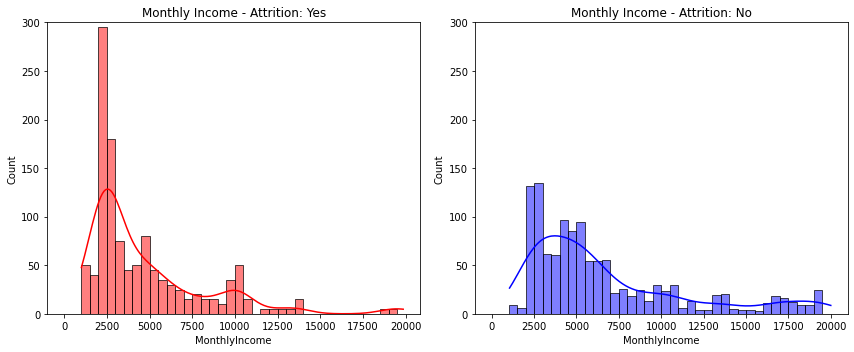

In [31]:
# Histogram of Monthly Income for Attrition

attrition_yes = df_dm.filter(df_dm['Attrition'] == 1)
attrition_no = df_dm.filter(df_dm['Attrition'] == 0)

attrition_yes_pd = attrition_yes.select("MonthlyIncome").toPandas()
attrition_no_pd = attrition_no.select("MonthlyIncome").toPandas()

bins = list(range(0, 20000, 500))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(attrition_yes_pd, x="MonthlyIncome", bins=bins, kde=True, ax=axes[0], color='red')
axes[0].set_title('Monthly Income - Attrition: Yes')
axes[0].set_ylim([0, 300])

sns.histplot(attrition_no_pd, x="MonthlyIncome", bins=bins, kde=True, ax=axes[1], color='blue')
axes[1].set_title('Monthly Income - Attrition: No')
axes[1].set_ylim([0, 300])

plt.tight_layout()
plt.show()

In [32]:
# Histogram of Years At Company for Attrition

attrition_yes_pandas = attrition_yes.select("YearsAtCompany").toPandas()
attrition_no_pandas = attrition_no.select("YearsAtCompany").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(attrition_yes_pandas, x="YearsAtCompany", kde=True, ax=axes[0], color='red')
axes[0].set_title('Years At Company - Attrition: Yes')

sns.histplot(attrition_no_pandas, x="YearsAtCompany", kde=True, ax=axes[1], color='blue')
axes[1].set_title('Years At Company - Attrition: No')

plt.tight_layout()
plt.show()

AnalysisException: cannot resolve 'YearsAtCompany' given input columns: [Age, Attrition, Department, DistanceFromHome, EnvironmentSatisfaction, JobSatisfaction, MonthlyIncome, NumCompaniesWorked, OverTime, StockOptionLevel, TotalWorkingYears, YearsInCurrentRole];
'Project ['YearsAtCompany]
+- Filter (Attrition#13 = cast(1 as double))
   +- Project [Age#0, DistanceFromHome#1, EnvironmentSatisfaction#2, JobSatisfaction#4, MonthlyIncome#5, NumCompaniesWorked#6, StockOptionLevel#7, TotalWorkingYears#8, YearsInCurrentRole#10, Attrition#13, Department#14, OverTime#15]
      +- Project [Age#0, DistanceFromHome#1, EnvironmentSatisfaction#2, JobSatisfaction#4, MonthlyIncome#5, NumCompaniesWorked#6, StockOptionLevel#7, TotalWorkingYears#8, YearsInCurrentRole#10, EducationField#12, Attrition#13, Department#14, OverTime#15]
         +- Project [Age#0, DistanceFromHome#1, EnvironmentSatisfaction#2, JobSatisfaction#4, MonthlyIncome#5, NumCompaniesWorked#6, StockOptionLevel#7, TotalWorkingYears#8, YearsAtCompany#9, YearsInCurrentRole#10, EducationField#12, Attrition#13, Department#14, OverTime#15]
            +- Project [Age#0, DistanceFromHome#1, EnvironmentSatisfaction#2, JobLevel#3, JobSatisfaction#4, MonthlyIncome#5, NumCompaniesWorked#6, StockOptionLevel#7, TotalWorkingYears#8, YearsAtCompany#9, YearsInCurrentRole#10, EducationField#12, Attrition#13, Department#14, OverTime#15]
               +- Relation [Age#0,DistanceFromHome#1,EnvironmentSatisfaction#2,JobLevel#3,JobSatisfaction#4,MonthlyIncome#5,NumCompaniesWorked#6,StockOptionLevel#7,TotalWorkingYears#8,YearsAtCompany#9,YearsInCurrentRole#10,YearsWithCurrManager#11,EducationField#12,Attrition#13,Department#14,OverTime#15] parquet


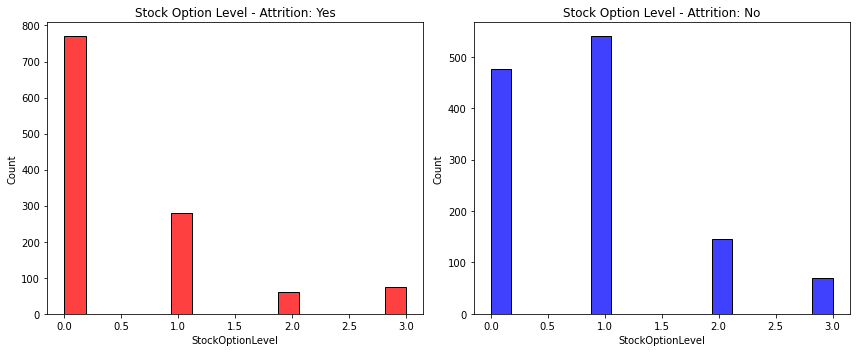

In [39]:
# Histogram of Stock Option Level for Attrition
attrition_yes_pandas = attrition_yes.select("StockOptionLevel").toPandas()
attrition_no_pandas = attrition_no.select("StockOptionLevel").toPandas()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms using Seaborn
sns.histplot(attrition_yes_pandas, x="StockOptionLevel", ax=axes[0], color='red')
axes[0].set_title('Stock Option Level - Attrition: Yes')

sns.histplot(attrition_no_pandas, x="StockOptionLevel", ax=axes[1], color='blue')
axes[1].set_title('Stock Option Level - Attrition: No')

plt.tight_layout()
plt.show()

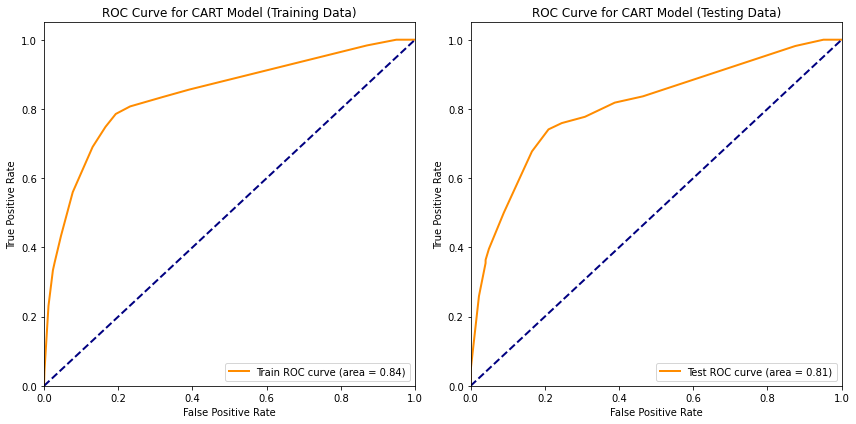

In [40]:
# ROC Curve

train_preds = model.transform(train_data).select("Attrition", "probability")
test_preds = model.transform(test_data).select("Attrition", "probability")

train_probs = train_preds.rdd.map(lambda row: (float(row["probability"][1]), float(row["Attrition"])))
test_probs = test_preds.rdd.map(lambda row: (float(row["probability"][1]), float(row["Attrition"])))

fpr_train, tpr_train, _ = roc_curve(train_probs.map(lambda x: x[1]).collect(), train_probs.map(lambda x: x[0]).collect())
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, _ = roc_curve(test_probs.map(lambda x: x[1]).collect(), test_probs.map(lambda x: x[0]).collect())
roc_auc_test = auc(fpr_test, tpr_test)

# Create ROC curves plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CART Model (Training Data)')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CART Model (Testing Data)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

In [42]:
# Bagging
feature_columns = [col_name for col_name in df_dm.columns if col_name != "Attrition"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dm_model = assembler.transform(df_dm)

(train_data, test_data) = df_dm_model.randomSplit([0.8, 0.2], seed=42)

num_trees = 10

tree_models = []

for i in range(num_trees):
    dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", seed=42 + i,maxDepth=5, maxBins=128)
    tree_model = dt_classifier.fit(train_data)
    tree_models.append(tree_model)

predictions = [model.transform(test_data) for model in tree_models]

def majority_vote(row):
    ones = sum(row)
    return 1 if ones >= num_trees / 2 else 0

ensemble_predictions = [prediction.select("prediction").rdd.map(lambda row: row[0]).collect() for prediction in predictions]
final_predictions = [majority_vote(row) for row in zip(*ensemble_predictions)]

true_labels = test_data.select("Attrition").rdd.map(lambda row: row[0]).collect()

In [43]:
# , minInstancesPerNode=5, minInfoGain=0.0

In [44]:
display(tree_model)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_8777513eac9a, depth=5, numNodes=49, numClasses=2, numFeatures=11

In [45]:
# Cross Validation to Get Best Parameters for Model
param_grid = ParamGridBuilder() \
    .addGrid(dt_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(dt_classifier.maxBins, [32, 64, 128]) \
    .build()

evaluator = BinaryClassificationEvaluator(labelCol="Attrition")

cross_validator = CrossValidator(estimator=dt_classifier,
                                 estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=5)

cv_model = cross_validator.fit(df_dm_model)

cv_scores = cv_model.avgMetrics
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.6491600044145449, 0.6818461679582247, 0.6914560156028465, 0.8635910069586981, 0.8779994147056187, 0.8808150839476334, 0.9220087417634726, 0.9222749356853139, 0.9245844125467269]


In [47]:
# Update model
feature_columns = [col_name for col_name in df_dm.columns if col_name != "Attrition"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_dm_model = assembler.transform(df_dm)

(train_data, test_data) = df_dm_model.randomSplit([0.8, 0.2], seed=42)

num_trees = 10

tree_models = []

for i in range(num_trees):
    dt_classifier = DecisionTreeClassifier(labelCol="Attrition", featuresCol="features", seed=42 + i,maxDepth=10, maxBins=32)
    tree_model = dt_classifier.fit(train_data)
    tree_models.append(tree_model)

predictions = [model.transform(test_data) for model in tree_models]

def majority_vote(row):
    ones = sum(row)
    return 1 if ones >= num_trees / 2 else 0

ensemble_predictions = [prediction.select("prediction").rdd.map(lambda row: row[0]).collect() for prediction in predictions]
final_predictions = [majority_vote(row) for row in zip(*ensemble_predictions)]

true_labels = test_data.select("Attrition").rdd.map(lambda row: row[0]).collect()

In [48]:
# accuracy
accuracy = accuracy_score(true_labels, final_predictions)
print("Accuracy of the Bagging Ensemble:", accuracy)

# confusion matrix
conf_matrix = confusion_matrix(true_labels, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# ROC curve
fpr, tpr, _ = roc_curve(true_labels, final_predictions)
roc_auc = auc(fpr, tpr)
print("Area under ROC:", roc_auc)

Accuracy of the Bagging Ensemble: 0.8828828828828829
Confusion Matrix:
[[183  41]
 [ 11 209]]
Area under ROC: 0.8834821428571429
